<a href="https://colab.research.google.com/github/VRamBalla/BME590-Protein-Design/blob/main/Project3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NOTE: This notebook assumes that the folder "team_5" is placed as a shortcut in your drive. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
import os
import sys
dataset_path = '/content/gdrive/My Drive/team_5/project_3/'
sys.path.append(dataset_path)

Mounted at /content/gdrive/


#Generation of Cas9 Contact Maps Using ProDy


ProDy is a free and open-source Python package for protein structural dynamics analysis.

In [ ]:
!pip install prody #Install proDy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 76.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 83.8 MB/s eta 0:00:00
  Created wheel for prody: filename=ProDy-2.4.0-cp39-cp39-linux_x86_64.whl size=17728034 sha256=02bc7ab3d10ece2b7e5cc87deb2077035c2f339088257f06bcecf01a39961b59
  Stored in directory: /root/.cache/pip/wheels/27/91/f2/fd8602a6d58d3b96f80d050a5925d90b62de46e0046eab9711
Successfully built prody


Import Necessary Modules

In [ ]:
from prody import *
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline
confProDy(auto_show=False)
confProDy(auto_secondary=True)
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

@> ProDy is configured: auto_show=False
INFO:.prody:ProDy is configured: auto_show=False
@> ProDy is configured: auto_secondary=True
INFO:.prody:ProDy is configured: auto_secondary=True


Experimentally derived 3D structures for Cas9 proteins were retreieved from Protein Data Bank. The PDB ids for these proteins were then aggregated into a csv file. 

In [ ]:
cas9_id = pd.read_csv(dataset_path + 'Cas9_ID.csv',header=None) #Read in csv file containing Cas9 PDB IDs
ids = cas9_id[0].tolist() #Put Cas9 PDB IDs to list

The code below generates contact maps based on the PDB Ids for proteins, given that they have experimentally determined 3D structures.

In [ ]:
pathPDBFolder(dataset_path+'ProDy_Files') #Set directory into which downloaded .pdb files will reside

for i in range(0,len(ids)): #For Loop iterating over entire set of Cas9 Ids
  backbone = parsePDB(ids[i],chain='A') #Extract backbone of protein from pdb file. These experimental compounds are usually in complex with other structures/molecules like water; This way only the protein is isolated from the structure
  plt.figure(figsize=(8,8)) #Set the figure size so that each image is a square; in this cass 800 x 800 pixels.
  showContactMap(backbone) #Display protein Contact Map
  plt.tight_layout() #Utilizes space in the figure effectively
  savefig(dataset_path+f'ContactMaps/{ids[i]}') #Save contact map as a PNG

#Retrieval of Distance Matrices Using ProDy
We were also able to retrieve Kirchoff distance matrices, which serve as the numerical representation of the contact map. **Unfortunately we ran into RAM issues when trying to pad these matrices to the same size for use in the subsequent diffusion model.** However, the code for retreiving the matrices is shown below

In [ ]:
def kirchhoff(protein):
  p = parsePDB(protein) #loads in pdb file for specified protein
  atoms = p.ca #Generates atom group from pdb file
  gnm = GNM(protein) #Instantiates an instance of prody's gaussian network model
  gnm.buildKirchhoff(atoms) #Builds distance matrix based on the atom group data from the pdb file
  K = gnm.getKirchhoff() #Retrieval of the Kirchoff Matrix
  D = np.diag(np.diag(K) + 1.) #Normalizes values in the Kirchoff Matrix
  A = D - K
  return A

In [ ]:
def getMatrices(filenames): #This function generates a dictionary of kirchoff matrices, mapping the protein ID to the kirchoff matrix
  d = {}
  for file in filenames:
    if file == None:
      continue
    K = kirchhoff(file)
    d[file] = K
  return d

In [ ]:
def pad_arrays(dict_arrays): #This function generates zero padding in the distance matrices so that they are all the same size for use in model training
  max_size = max(array.shape[0] for array in dict_arrays.values()) # get the largest dimension
  padded_dict = {}
  for key, array in dict_arrays.items():
    pad_width = [(0, max_size - array.shape[0]), (0, max_size - array.shape[1])] # calculate padding required
    padded_array = np.pad(array, pad_width, mode='constant', constant_values=0) # pad the array with zeros
    padded_dict[key] = padded_array
  return padded_dict

In [ ]:
kirchhoff_matrices = getMatrices(ids) #This code calls on prody to retrieve the distance matrices for all of the Cas9 Ids

This code is commented because creating the zeropadding overloads the RAM avaailable. It is for this reason that Diffusion was carried out on the PNGs of the contact maps

In [ ]:
#padded_kirchhoff = pad_arrays(kirchhoff_matrices)

#Diffusion Model Training with Contact Maps

The annotated diffusion model on hugging face written by Niels Rogge and Kashif Rasul was used to carry out diffusion on the contact maps.

The link to the hugging face model is given here:
https://huggingface.co/blog/annotated-diffusion



In [ ]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

First, we define some helper functions and classes which will be used when implementing the neural network. Importantly, we define a Residual module, which simply adds the input to the output of a particular function (in other words, adds a residual connection to a particular function).

We also define aliases for the up- and downsampling operations.

In [ ]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Position embeddings

As the parameters of the neural network are shared across time (noise level), the authors employ sinusoidal position embeddings to encode $t$, inspired by the Transformer ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)). This makes the neural network "know" at which particular time step (noise level) it is operating, for every image in a batch.

The `SinusoidalPositionEmbeddings` module takes a tensor of shape `(batch_size, 1)` as input (i.e. the noise levels of several noisy images in a batch), and turns this into a tensor of shape `(batch_size, dim)`, with `dim` being the dimensionality of the position embeddings. This is then added to each residual block, as we will see further.

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet/ConvNeXT block

Next, we define the core building block of the U-Net model. The DDPM authors employed a Wide ResNet block ([Zagoruyko et al., 2016](https://arxiv.org/abs/1605.07146)), but Phil Wang decided to also add support for a ConvNeXT block ([Liu et al., 2022](https://arxiv.org/abs/2201.03545)), as the latter has achieved great success in the image domain. One can choose one or another in the final U-Net architecture.

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

### Attention module

Next, we define the attention module, which the DDPM authors added in between the convolutional blocks. Attention is the building block of the famous Transformer architecture ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)), which has shown great success in various domains of AI, from NLP and vision to [protein folding](https://www.deepmind.com/blog/alphafold-a-solution-to-a-50-year-old-grand-challenge-in-biology). Phil Wang employs 2 variants of attention: one is regular multi-head self-attention (as used in the Transformer), the other one is a [linear attention variant](https://github.com/lucidrains/linear-attention-transformer) ([Shen et al., 2018](https://arxiv.org/abs/1812.01243)), whose time- and memory requirements scale linear in the sequence length, as opposed to quadratic for regular attention.

For an extensive explanation of the attention mechanism, we refer the reader to Jay Allamar's [wonderful blog post](https://jalammar.github.io/illustrated-transformer/).

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization

The DDPM authors interleave the convolutional/attention layers of the U-Net with group normalization ([Wu et al., 2018](https://arxiv.org/abs/1803.08494)). Below, we define a `PreNorm` class, which will be used to apply groupnorm before the attention layer, as we'll see further. Note that there's been a [debate](https://tnq177.github.io/data/transformers_without_tears.pdf) about whether to apply normalization before or after attention in Transformers.

In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Conditional U-Net

Now that we've defined all building blocks (position embeddings, ResNet/ConvNeXT blocks, attention and group normalization), it's time to define the entire neural network. Recall that the job of the network \\(\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)\\) is to take in a batch of noisy images + noise levels, and output the noise added to the input. More formally:

- the network takes a batch of noisy images of shape `(batch_size, num_channels, height, width)` and a batch of noise levels of shape `(batch_size, 1)` as input, and returns a tensor of shape `(batch_size, num_channels, height, width)`

The network is built up as follows:
* first, a convolutional layer is applied on the batch of noisy images, and position embeddings are computed for the noise levels
* next, a sequence of downsampling stages are applied. Each downsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + a downsample operation
* at the middle of the network, again ResNet or ConvNeXT blocks are applied, interleaved with attention
* next, a sequence of upsampling stages are applied. Each upsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + an upsample operation
* finally, a ResNet/ConvNeXT block followed by a convolutional layer is applied.

Ultimately, neural networks stack up layers as if they were lego blocks (but it's important to [understand how they work](http://karpathy.github.io/2019/04/25/recipe/)).


In [ ]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## Defining the forward diffusion process

The forward diffusion process gradually adds noise to an image from the real distribution, in a number of time steps $T$. This happens according to a **variance schedule**. In this case, we used a quadratic variance schedule.

In [ ]:
def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2


In [ ]:
timesteps = 200 #Utilize 200 time steps in the noising process

# define beta schedule
betas = quadratic_beta_schedule(timesteps=timesteps)

# define alphas; the cumulative products of the variances
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

We'll illustrate with an example contact map how noise is added at each time step of the diffusion process.

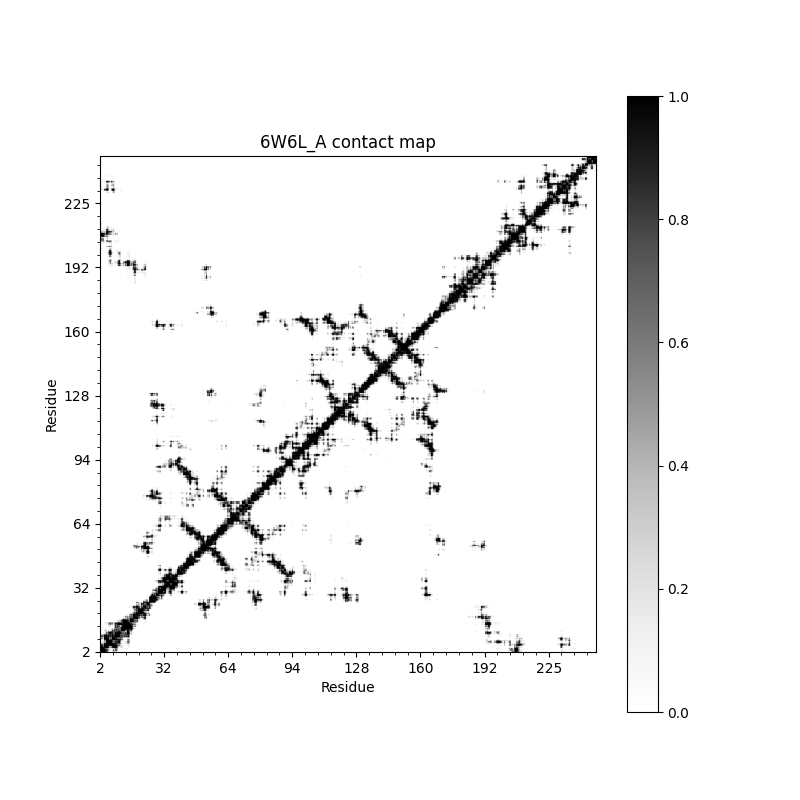

In [ ]:
from PIL import Image
import requests

image = Image.open(dataset_path+"ContactMaps/6W6L.png")
image

This code resizes the image (in this case to a 256x256 image from 800x800) and converts the image to a tensor.

In [ ]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 256
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
    
])

x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 4, 256, 256])

This code takes the tensor and reconstructs the image. The example shows the reconstruction of the contact map in 256x256 from the tensor

In [ ]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

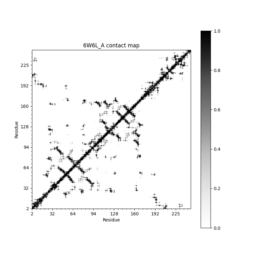

In [ ]:
reverse_transform(x_start.squeeze())

This code block summarizes the forward diffusion process, in which noise is progressively added to the image.

In [ ]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

This code block defines the loss functions for the model

In [ ]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

The `denoise_model` will be our U-Net defined above. We'll employ the Huber loss between the true and the predicted noise.

## Define a PyTorch Dataset + DataLoader

Here we load in the contact map images generated. 

Each image is at 800x800 pixels, which is then resized to 200x200. Interesting to note is that images are also randomly horizontally flipped. From the paper:

> We used random horizontal flips during training for CIFAR10; we tried training both with and without flips, and found flips to improve sample quality slightly.



In [ ]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset(dataset_path+'ContactMaps')
image_size = 200
channels = 1
batch_size = 10
dataset['train'][0]

Resolving data files:   0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x800 at 0x7F3E0C32FA00>}

Next, we define a function which we'll apply on-the-fly on the entire dataset. We use the `with_transform` [functionality](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Dataset.with_transform) for that. The function just applies some basic image preprocessing: random horizontal flips, rescaling and finally make them have values in the $[-1,1]$ range.

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

# define image transformations (e.g. using torchvision)
transform = Compose([
            Resize(image_size),
            CenterCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms)

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


## Sampling

Generating new images from a diffusion model happens by reversing the diffusion process: we start from $T$, where we sample pure noise from a Gaussian distribution, and then use our neural network to gradually denoise it (using the conditional probability it has learned), until we end up at time step $t = 0$. As shown above, we can derive a slighly less denoised image $\mathbf{x}_{t-1 }$ by plugging in the reparametrization of the mean, using our noise predictor. Remember that the variance is known ahead of time.

Ideally, we end up with an image that looks like it came from the real data distribution.

The code below implements this.

In [ ]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


Note that the code above is a simplified version of the original implementation. We found our simplification (which is in line with Algorithm 2 in the paper) to work just as well as the [original, more complex implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/diffusion_utils.py).


## Train the model

Next, we train the model in regular PyTorch fashion. We also define some logic to peridiocally save generated images, using the `sample` method defined above.


In [ ]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

Below, we define the model, and move it to the GPU. We also define a standard optimizer (Adam).

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-6) #learning rate 1e-6

Let's start training!
We are utilizing 20 epochs, so the data will be forward-passed 20 times. After each epoch, the loss value will be returned.

In [ ]:
from torchvision.utils import save_image

epochs = 20

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Loss: 0.45572686195373535
Loss: 0.4231773316860199
Loss: 0.4120996296405792
Loss: 0.3883650600910187
Loss: 0.3444807827472687
Loss: 0.3518114686012268
Loss: 0.2879170775413513
Loss: 0.21072164177894592
Loss: 0.245469331741333
Loss: 0.18747802078723907
Loss: 0.13806767761707306
Loss: 0.14946861565113068
Loss: 0.11444682627916336
Loss: 0.12907859683036804
Loss: 0.09044839441776276
Loss: 0.11804509162902832
Loss: 0.10830406844615936
Loss: 0.11537845432758331
Loss: 0.12322982400655746
Loss: 0.07937337458133698


## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [ ]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

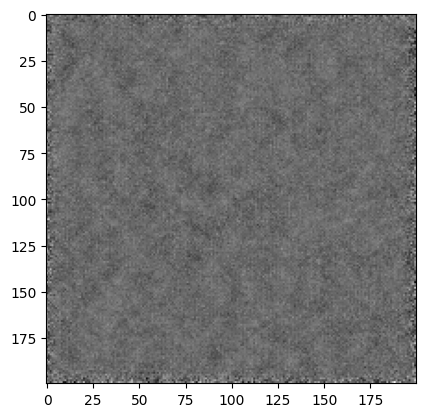

In [ ]:
# show a random one
random_index = 50
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")